In [11]:
#STEP 2: Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [12]:
uploaded = files.upload()
met_file = "P den_Metabolites_OD_0.6.xlsx"
prot_file = "P den_OD_0.6_proteome data_P value.xlsx"

Saving P den_Metabolites_OD_0.6.xlsx to P den_Metabolites_OD_0.6 (1).xlsx
Saving P den_OD_0.6_proteome data_P value.xlsx to P den_OD_0.6_proteome data_P value (1).xlsx


In [13]:
met_df = pd.read_excel(met_file)
prot_df = pd.read_excel(prot_file)

In [14]:
# STEP 4: Prepare OD = 0.6 data
sample_cols = ['WT1', 'WT2', 'WT3', 'HNOX1', 'HNOX2', 'HNOX3']
X_raw = met_df[sample_cols].T
X_raw.columns = met_df['Metabolite_ID']
Y_raw = prot_df[sample_cols].T
Y_raw.columns = prot_df['Protein_ID']
# Standard scaling
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
Y_scaled = scaler_Y.fit_transform(Y_raw)
X_scaled = np.nan_to_num(X_scaled)
Y_scaled = np.nan_to_num(Y_scaled)

In [15]:
# STEP 5: Define Models for LOOCV
models = {
    "PLS": PLSRegression(n_components=5),
    "Ridge": MultiOutputRegressor(Ridge(alpha=1.0)),
    "Lasso": MultiOutputRegressor(Lasso(alpha=0.01, max_iter=10000)),
    "RandomForest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "XGBoost": MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=42))
}

In [26]:
# STEP 6: LOOCV for Each Model
loo = LeaveOneOut()
r2_loocv = {}
mse_loocv = {}
std_r2 = {}
std_mse = {}

ridge_preds_all, ridge_actual_all = [], []

for name, model in models.items():
    r2_list, mse_list = [], []
    for train_idx, test_idx in loo.split(X_scaled):
        X_tr, X_te = X_scaled[train_idx], X_scaled[test_idx]
        Y_tr, Y_te = Y_scaled[train_idx], Y_scaled[test_idx]
        model.fit(X_tr, Y_tr)
        Y_pred = model.predict(X_te)
        Y_pred_inv = scaler_Y.inverse_transform(Y_pred)
        Y_true_inv = scaler_Y.inverse_transform(Y_te)
        r2 = r2_score(Y_true_inv.flatten(), Y_pred_inv.flatten())
        mse = mean_squared_error(Y_true_inv.flatten(), Y_pred_inv.flatten())
        r2_list.append(r2)
        mse_list.append(mse)
        if name == "Ridge":
            ridge_preds_all.append(Y_pred_inv.flatten())
            ridge_actual_all.append(Y_true_inv.flatten())
    r2_loocv[name] = np.mean(r2_list)
    mse_loocv[name] = np.mean(mse_list)
    std_r2[name] = np.std(r2_list)
    std_mse[name] = np.std(mse_list)

/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 4
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 4
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 4
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 4
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 4
  warnings.warn(f"y residual is constant at iteration {k}")
/usr/local/lib/python3.11/dist-packages/


LOOCV Model Performance Comparison (on OD = 0.6 data):
              R2_mean   R2_std  MSE_mean  MSE_std
PLS           0.99143  0.00732   0.08323  0.07073
Ridge         0.99462  0.00190   0.05230  0.01847
Lasso         0.98870  0.00286   0.10985  0.02759
RandomForest  0.99169  0.00220   0.08092  0.02175
XGBoost       0.98256  0.01422   0.16965  0.13849


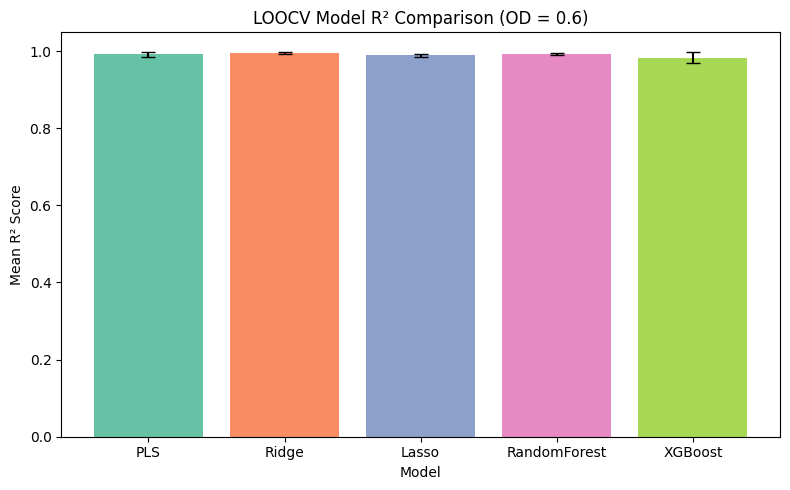

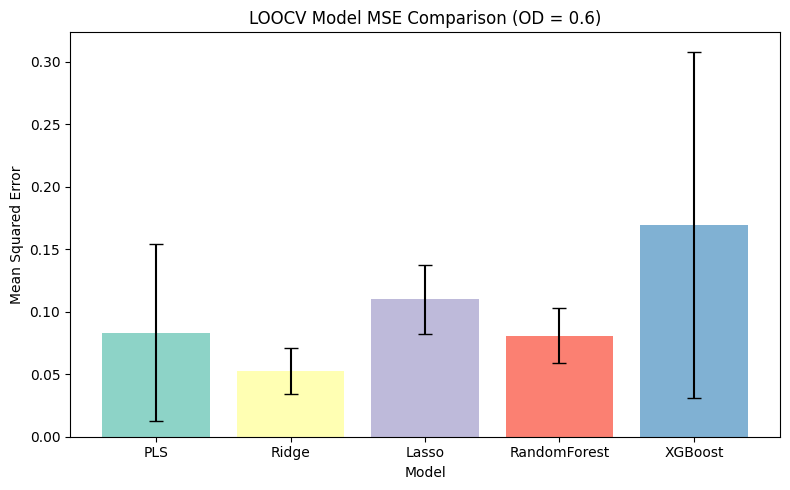

In [27]:
# STEP 7: Show LOOCV Performance Comparison
results_df = pd.DataFrame({
    "R2_mean": r2_loocv,
    "R2_std": std_r2,
    "MSE_mean": mse_loocv,
    "MSE_std": std_mse
})
print("\nLOOCV Model Performance Comparison (on OD = 0.6 data):")
print(results_df.round(5))

# STEP 8: Bar plot of LOOCV R² scores with error bars
plt.figure(figsize=(8, 5))
r2_keys = list(r2_loocv.keys())
r2_means = list(r2_loocv.values())
r2_stds = list(std_r2.values())
colors = sns.color_palette("Set2", len(r2_keys))
for i, (bar, err) in enumerate(zip(r2_means, r2_stds)):
    plt.bar(r2_keys[i], bar, yerr=err, capsize=5, color=colors[i])
plt.title("LOOCV Model R² Comparison (OD = 0.6)")
plt.xlabel("Model")
plt.ylabel("Mean R² Score")
plt.tight_layout()
plt.show()

# STEP 9: Bar plot of LOOCV MSE with error bars
plt.figure(figsize=(8, 5))
mse_keys = list(mse_loocv.keys())
mse_means = list(mse_loocv.values())
mse_stds = list(std_mse.values())
colors = sns.color_palette("Set3", len(mse_keys))
for i, (bar, err) in enumerate(zip(mse_means, mse_stds)):
    plt.bar(mse_keys[i], bar, yerr=err, capsize=5, color=colors[i])
plt.title("LOOCV Model MSE Comparison (OD = 0.6)")
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.tight_layout()
plt.show()


In [28]:
# STEP 10: Export LOOCV results table to CSV
results_df.round(5).to_csv("LOOCV_Model_Performance_OD0.6.csv")
files.download("LOOCV_Model_Performance_OD0.6.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

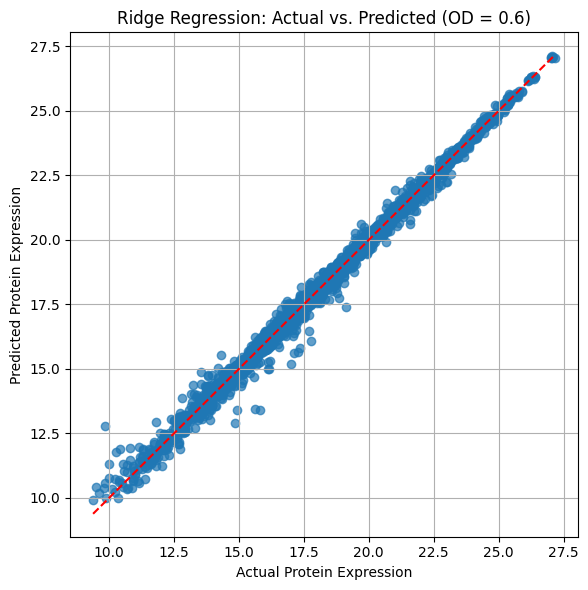

In [29]:
# STEP 11: Plot actual vs predicted for Ridge (best model)
ridge_actual_flat = np.concatenate(ridge_actual_all)
ridge_pred_flat = np.concatenate(ridge_preds_all)

plt.figure(figsize=(6, 6))
plt.scatter(ridge_actual_flat, ridge_pred_flat, alpha=0.7)
plt.plot([min(ridge_actual_flat), max(ridge_actual_flat)],
         [min(ridge_actual_flat), max(ridge_actual_flat)], 'r--')
plt.xlabel("Actual Protein Expression")
plt.ylabel("Predicted Protein Expression")
plt.title("Ridge Regression: Actual vs. Predicted (OD = 0.6)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# STEP 12: Apply Ridge model to OD = 2 data
uploaded = files.upload()
od2_file = "P den_Metabolites_OD_2.xlsx"
od2_df = pd.read_excel(od2_file)

Saving P den_Metabolites_OD_2.xlsx to P den_Metabolites_OD_2.xlsx


In [33]:
# Prepare OD=2 input (same metabolites)
od2_X = od2_df.set_index("Metabolite_ID").T
od2_X = od2_X.loc[:, ~od2_X.columns.duplicated()]
od2_X = od2_X[scaler_X.feature_names_in_] if all(col in od2_X.columns for col in scaler_X.feature_names_in_) else od2_X.reindex(columns=scaler_X.feature_names_in_, fill_value=0.0)
od2_X_scaled = scaler_X.transform(np.nan_to_num(od2_X))

# Retrain best Ridge model on all OD = 0.6 data
ridge_model = MultiOutputRegressor(Ridge(alpha=1.0))
ridge_model.fit(X_scaled, Y_scaled)

# Predict protein expression at OD = 2
Y_od2_scaled_pred = ridge_model.predict(od2_X_scaled)
Y_od2_pred = scaler_Y.inverse_transform(Y_od2_scaled_pred)
Y_od2_pred_df = pd.DataFrame(Y_od2_pred, index=od2_X.index, columns=Y_raw.columns)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [36]:
# Export OD = 2 predictions
#Y_od2_pred_df.to_csv("Ridge_Predicted_Protein_Expression_OD2.csv")
#files.download("Ridge_Predicted_Protein_Expression_OD2.csv")

Y_od2_pred_df_transposed = Y_od2_pred_df.T
Y_od2_pred_df_transposed.to_csv("Ridge_Predicted_Protein_Expression_OD2_transposed.csv")
files.download("Ridge_Predicted_Protein_Expression_OD2_transposed.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>